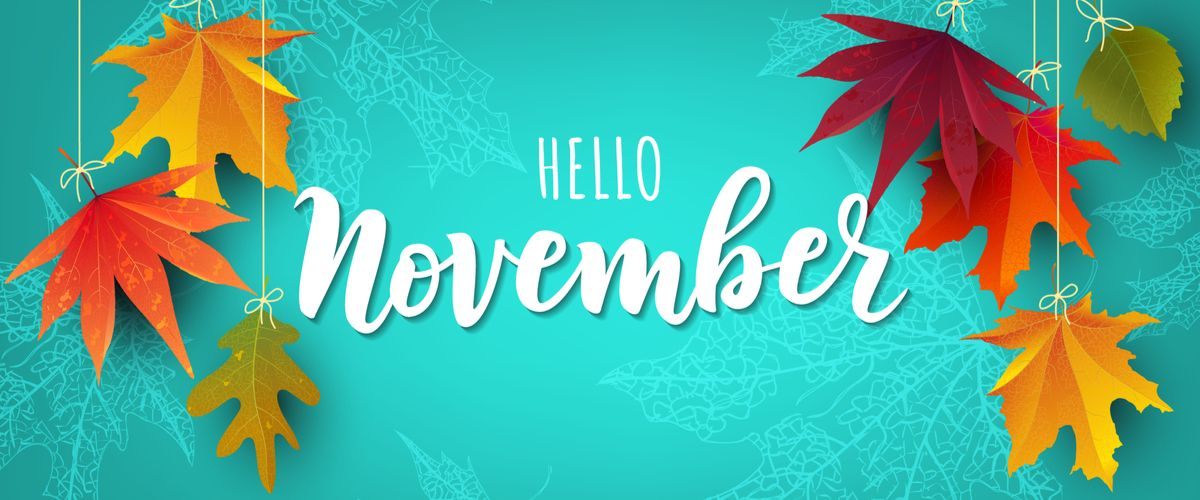

# 🔥TPS NOVEMBER 
## This Notebook is purely the implementation of the autoxgb written by Abhishek https://www.kaggle.com/abhishek
### I have done a simple EDA and trained using Autoxgb, loaded the model and created the submission file.
### Note- No FE was done and it's a single model.

In [ ]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import datatable as dt



In [ ]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [ ]:
%%time
train = dt.fread('../input/tabular-playground-series-nov-2021/train.csv').to_pandas().drop('id', axis=1)
train = reduce_memory_usage(train)
test = dt.fread('../input/tabular-playground-series-nov-2021/test.csv').to_pandas().drop('id', axis=1)
test = reduce_memory_usage(test)
ss = dt.fread('../input/tabular-playground-series-nov-2021/sample_submission.csv').to_pandas()
ss = reduce_memory_usage(ss)

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
display(train.isna().sum().sum())
display(test.isna().sum().sum())

In [ ]:
train.describe().T

In [ ]:
train

In [ ]:
#Lets find traget variable distribution
target_varibale=train['target']
pal = ['#5ddef4','#8e99f3']
plt=sns.countplot(x=train.target,palette=pal)
plt.set_title('Target  distribution', fontsize=20, y=1.05)

In [ ]:
train.dtypes


In [ ]:
categorical_features=[]
numerical_features=[]
for i in train.columns:
    if train[i].dtype=='float16':
#         print('yes')
        numerical_features.append(i)
    elif i!='target':
        categorical_features.append(i)
#         print('no')

In [ ]:
display(len(categorical_features))
display(len(numerical_features))

### NOTE- There are no categorical features

In [ ]:
df_num_features = pd.concat([train[numerical_features], train['target']], axis=1) # still writing even though train and this frame will be same

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16 , 16))
corr = df_num_features.sample(10000, random_state=2021).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, ax=ax, square=True, center=0, linewidth=1,
        cmap=sns.diverging_palette(0,255,sep=77, as_cmap=True),vmax=0.5, vmin=-0.5,
        cbar_kws={"shrink": .85}, mask=mask )
ax.set_title('Correlation heatmap: Numerical features', fontsize=24, y= 1.05)
plt.show()

### WOW just wow


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = train.drop('target',axis=1)
y = train['target']
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    

In [ ]:
pca = PCA(n_components=2)
x_new = pca.fit_transform(X)

In [ ]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [ ]:
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())


In [ ]:
explained_variance=pca.explained_variance_ratio_

In [ ]:
explained_variance_list=explained_variance.tolist()

In [ ]:
explained_variance_list
sum(explained_variance_list[0:85])

In [ ]:
print(abs( pca.components_ [0]))

In [ ]:
with plt.style.context('seaborn-ticks'):
    plt.figure(figsize=(10, 12))

    plt.bar(range(100), explained_variance, alpha=0.8, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
model = PCA(n_components=50).fit(X)
X_pc = model.transform(X)

n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]


# get the names
most_important_names = [numerical_features[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [ ]:
most_important

In [ ]:
df

In [ ]:
# !pip install  autoxgb 

In [ ]:
!autoxgb train \
--train_filename ../input/tabular-playground-series-nov-2021/train.csv \
--test_filename ../input/tabular-playground-series-nov-2021/test.csv \
--id IDX \
--target target \
--task classification \
--time_limit 3600 \
--output ./kk \
--use_gpu

In [ ]:
import joblib

xgb_model = joblib.load('./kk/axgb_model.4')


In [ ]:
pred_df=dt.fread('./kk/test_predictions.csv').to_pandas()

final_class=[]
for i in pred_df.iterrows():
    current_class=1
    if i[1][1] >i[1][2]:
        current_class=0
        final_class.append(current_class)
    else:
         final_class.append(current_class)
        
    

In [ ]:
len(final_class)
set(final_class)

In [ ]:
ss = dt.fread('../input/tabular-playground-series-nov-2021/sample_submission.csv').to_pandas()
ss['target'] = final_class
ss.to_csv('xgb1111.csv', index=False)
ss.head()

In [ ]:
import gc
X = train.drop('target', axis=1).copy()
y = train['target'].copy()
X_test = test.copy()

del train
del test
gc.collect()

In [ ]:


kf= StratifiedKFold(n_splits=5,shuffle=True,random_state=786)
preds=[]
scores=[]
for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    model=LGBMClassifier()
    model.fit(X_train, y_train,
              eval_set = [(X_valid, y_valid)],
              verbose = True,
              early_stopping_rounds = 300)
    
    pred_valid = model.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)
    
    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print('||'*40, "\n")
    
    test_preds = model.predict_proba(X_test)[:,1]
    preds.append(test_preds)
    
print(f"Overall Validation Score: {np.mean(scores)}")

In [ ]:
model.booster_.save_model('model_lgbm.txt')

In [ ]:
predictions = np.mean(np.column_stack(preds),axis=1)

ss['target'] = predictions
ss.to_csv('lgbm_submission1.csv', index=False)
ss.head()

# WORK IN PROGRESS FOR OPTUNA HP tuning, also will add averaging of submissions later.

In [ ]:
!pip install optuna

In [ ]:
 params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 0, 100),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 1.0),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 15),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 100, 500),
        "n_estimators": trial.suggest_categorical("n_estimators", [7000, 15000, 20000]),
        "booster": "gbtree",
        "eval_metric": "auc",
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "use_label_encoder": True
    }

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
def optimize(trial,x=X,y=y):
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=786)
    
       
    

    preds = []
    scores = []

    for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
        learning_rate=trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
        reg_lambda= trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True)
        reg_alpha= trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True)
        subsample= trial.suggest_float("subsample", 0.1, 1.0)
        min_child_weight=trial.suggest_int("min_child_weight", 0, 100)
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.1, 1.0)
        max_depth=trial.suggest_int("max_depth", 1, 15)
        early_stopping_rounds=trial.suggest_int("early_stopping_rounds", 100, 500)
        
        
        
        
        
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        
        model = XGBClassifier(n_estimators=14000,
                  learning_rate=learning_rate,
                  reg_lambda=reg_lambda,
                  reg_alpha=reg_alpha,
                  subsample=subsample,
                  min_child_weight=min_child_weight,
                  colsample_bytree=colsample_bytree,
                  max_depth=max_depth,
                  early_stopping_rounds=early_stopping_rounds,
                  tree_method="gpu_hist",
                  predictor="gpu_predictor",
                  eval_metric= 'auc',
                  use_label_encoder= True)

        model.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_valid,y_valid)],
                  verbose=True)

        pred_valid = model.predict_proba(X_valid)[:,1]
        fpr, tpr, _ = roc_curve(y_valid, pred_valid)
        score = auc(fpr, tpr)
        scores.append(score)

        print(f"Fold: {fold + 1} Score: {score}")
        print('||'*40)

        test_preds = model.predict_proba(X_test)[:,1]
        preds.append(test_preds)

    print(f"Overall Validation Score: {np.mean(scores)}")

In [ ]:
from functools import partial
study = optuna.create_study(direction="minimize", study_name="Xgb Classifier")
optimization_function=partial(optimize,x=X,y=y)
study.optimize(optimization_function, n_trials=20)

In [ ]:
study.best_params

In [ ]:
X = train.drop('target', axis=1).copy()
y = train['target'].copy()
X_test = test.copy()

del train
del test

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=786)

preds = []
scores = []

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    model3 = XGBClassifier(**params)
    
    model3.fit(X_train,y_train,
              eval_set=[(X_train, y_train),(X_valid,y_valid)],
              early_stopping_rounds=200,
              verbose=True)
    
    pred_valid = model3.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, pred_valid)
    score = auc(fpr, tpr)
    scores.append(score)
    
    print(f"Fold: {fold + 1} Score: {score}")
    print('||'*40)
    
    test_preds = model3.predict_proba(X_test)[:,1]
    preds.append(test_preds)
    
print(f"Overall Validation Score: {np.mean(scores)}")